---
title: 'Parameter Studies'
toc: true
number-sections: true
mainfont: Arial
format:
  html: default
jupyter: python3
---

In [39]:
#| echo: false
#| output: false
%load_ext autoreload
%autoreload 2
import sys

sys.path.append(r"..\..\src")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

This tutorial shows how to perform parameter studies in a concise and structured way and to generate targeted parameter modifications with minimal code. Compared to the 'Study Cases' tutorial, the focus is not on creating study cases, variations and operation scenarios, but rather on the parameter sets. 

First, we activate the PowerFactory project, i.e. the *IEEE 39 bus system*.

In [40]:
# If you use IPython/Jupyter:
import sys

sys.path.append(
    r"C:\Program Files\DIgSILENT\PowerFactory 2025 SP3\Python\3.13"
)  # you may use a different directory

# Get the PF app
import powerfactory
import powfacpy

app = powerfactory.GetApplication()
app.Show()
app.ActivateProject(
    r"powfacpy\39_bus_new_england_copy_where_tests_run"
)  # You may change the project path.


0

We create a copy of the study case that simulates a fault at bus 16 and clear all result variables.

In [41]:
from powfacpy.base.active_project import ActiveProject

act_prj = ActiveProject(app)
act_prj.create_study_case("Parameter Study", r"Study Cases\2.1 Simulation Fault Bus 16 Stable", parent_folder=r"Study Cases\powfacpy")
act_prj.clear_results_variables()


We get all synchronous machines and their types and their rotor speed as monitored result varibales.

In [42]:
from powfacpy.result_variables import ResVar
RMS_BAL = ResVar.RMS_Bal

try:
    app.Hide()
    synchronous_machines = act_prj.get_calc_relevant_obj("ElmSym")
    synchronous_machines.sort(key=lambda x: x.loc_name)
    synchronous_machine_types = [sm.typ_id for sm in synchronous_machines]
    act_prj.add_results_variable(synchronous_machines, RMS_BAL.ElmSym.s_speed.value)
finally:
    app.Show()
synchronous_machines    

[<powerfactory.DataObject <l1>\seberlein.IntUser\powfacpy\39_bus_new_england_copy_where_tests_run.IntPrj\Network Model.IntPrjfolder\Network Data.IntPrjfolder\Grid.ElmNet\G 01.ElmSym</l1>>,
 <powerfactory.DataObject <l1>\seberlein.IntUser\powfacpy\39_bus_new_england_copy_where_tests_run.IntPrj\Network Model.IntPrjfolder\Network Data.IntPrjfolder\Grid.ElmNet\G 02.ElmSym</l1>>,
 <powerfactory.DataObject <l1>\seberlein.IntUser\powfacpy\39_bus_new_england_copy_where_tests_run.IntPrj\Network Model.IntPrjfolder\Network Data.IntPrjfolder\Grid.ElmNet\G 03.ElmSym</l1>>,
 <powerfactory.DataObject <l1>\seberlein.IntUser\powfacpy\39_bus_new_england_copy_where_tests_run.IntPrj\Network Model.IntPrjfolder\Network Data.IntPrjfolder\Grid.ElmNet\G 04.ElmSym</l1>>,
 <powerfactory.DataObject <l1>\seberlein.IntUser\powfacpy\39_bus_new_england_copy_where_tests_run.IntPrj\Network Model.IntPrjfolder\Network Data.IntPrjfolder\Grid.ElmNet\G 05.ElmSym</l1>>,
 <powerfactory.DataObject <l1>\seberlein.IntUser\powfac

# Definition of Variants


We define the parameter sets to be simulated by instantiating the `Variant` class. This class provides a concise and structured way to generate targeted parameter modifications with minimal code. Two representative examples are outlined below.

---

**Variant 1**: *“All SM (H, mult.)”*

This variant modifies the inertia constant (`tag`) of all synchronous machine (SM) types. The original inertia values are scaled multiplicatively by factors ranging from 0.6 to 1.4, distributed over four equidistant steps.

The first plot below illustrates the resulting inertia constants for all SM types across these scaling factors.

Note that, in addition to multiplicative scaling, the `Variant` class also supports alternative modification schemes, such as additive offsets to the original parameter values.

---

**Variant 2**: *"All SM (H, grad.)"*

The second variant also targets the inertia constants but applies a gradient distribution (`var.variation_type = "gradient"`).

As shown in the second plot below:

* The inertia of the first generator (Gen 01) is varied from 6 to 10.
* The inertia of the last generator (Gen 10) is varied from 10 to 6.
* etc.

This creates a linear gradient across the generator fleet while preserving the overall average inertia of the system (though relative to the nominal power of the generators).



In [43]:
from powfacpy.applications.parameter_studies import Variant

try:
    app.Hide()
    
    variants = []

    var = Variant(app)
    var.name = "All SM (H, mult.)"
    var.objs_and_attr = [synchronous_machine_types, "tag"]
    var.par_range = [0.6, 1.4]
    var.steps = 4
    var.value_calculation = "multiply" # other options are e.g. "add"
    var.initialize()
    variants.append(var)
    
    var = Variant(act_prj.app)
    var.name = "All SM (H, grad.)"
    var.objs_and_attr = [synchronous_machine_types, "tag"]
    var.par_range = [6, 10]
    var.steps = 4
    var.value_calculation = "equal"
    var.variation_type = "gradient"
    var.initialize()
    variants.append(var)

finally:
    app.Show()    

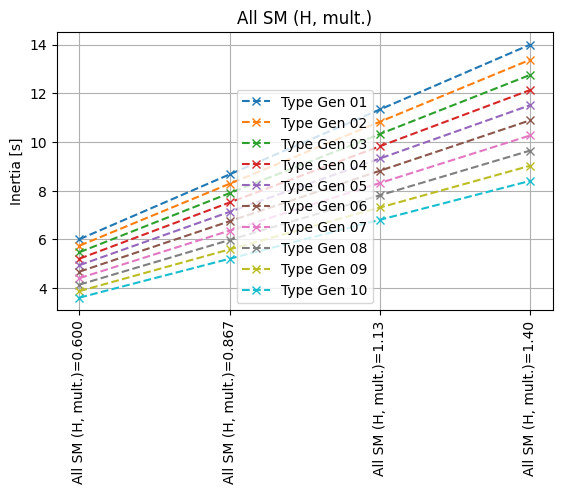

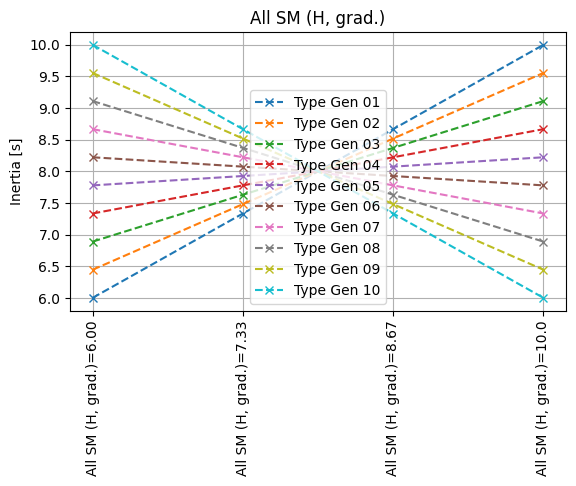

In [59]:
import matplotlib.pyplot as plt

plt.rcParams.update({"axes.grid" : True})
for var in variants:
    plt.figure()
    for sm, h_values in var.values.items():
        plt.plot(h_values, linestyle='--', marker='x', label=sm[0].loc_name)
    plt.xticks(
        ticks=list(range(len(var.names_for_each_value  ))),
        labels=var.names_for_each_value,
    )
    plt.xticks(rotation=90)
    plt.ylabel("Inertia [s]")
    plt.subplots_adjust(bottom=0.3)    
    plt.title(var.name)
    plt.legend()

# The `ParameterStudy` Class


The `ParameterStudy` class offers an interface to several `Variants`.

In [45]:
from powfacpy.applications.parameter_studies import ParameterStudy
from powfacpy.result_variables import ResVar
RMS_BAL = ResVar.RMS_Bal

try:
    app.Hide()
    parstudy = ParameterStudy()
    parstudy.variants = variants
    parstudy.initialize()
finally:
    app.Show()   

As shown in the plot below, the values of the parameter sets of both variants can be accessed and compared.

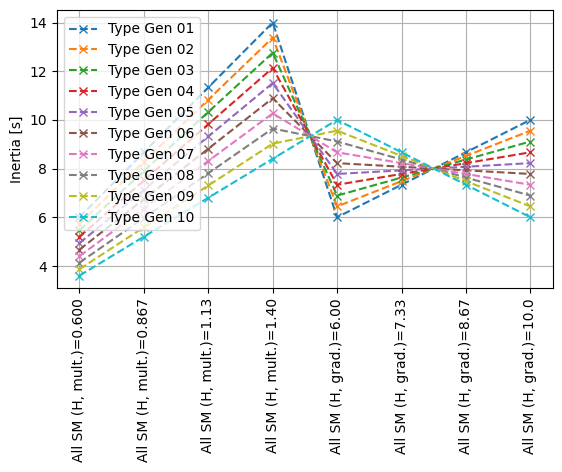

In [61]:
for sm, h_values in parstudy.values.items():
    plt.plot(h_values, linestyle='--', marker='x', label=sm[0].loc_name)
simulation_names = parstudy.get_all_names()    
plt.xticks(
    ticks=list(range(len(simulation_names))),
    labels=simulation_names,
)
plt.xticks(rotation=90)
plt.ylabel("Inertia [s]")
plt.subplots_adjust(bottom=0.3)    
plt.legend()    

We can now iterate all parameters sets and perform any kind of simulation or calculation. The values for each step are automatically set in *PowerFactory*.

In [ ]:
try:
    app.Hide()
    for values, sim_name in parstudy.step_generator():
        print(sim_name)
        print(values)
        # perform any kind of calculation
    parstudy.set_default_values()     
finally:
    app.Show()

All SM (H, mult.)=0.600
{(<powerfactory.DataObject <l1>\seberlein.IntUser\powfacpy\39_bus_new_england_copy_where_tests_run.IntPrj\Library.IntPrjfolder\Equipment Type Library.IntPrjfolder\Generator Types.IntPrjfolder\Type Gen 01.TypSym</l1>>, 'tag'): np.float64(6.0), (<powerfactory.DataObject <l1>\seberlein.IntUser\powfacpy\39_bus_new_england_copy_where_tests_run.IntPrj\Library.IntPrjfolder\Equipment Type Library.IntPrjfolder\Generator Types.IntPrjfolder\Type Gen 02.TypSym</l1>>, 'tag'): np.float64(5.7333332061767575), (<powerfactory.DataObject <l1>\seberlein.IntUser\powfacpy\39_bus_new_england_copy_where_tests_run.IntPrj\Library.IntPrjfolder\Equipment Type Library.IntPrjfolder\Generator Types.IntPrjfolder\Type Gen 03.TypSym</l1>>, 'tag'): np.float64(5.466666412353516), (<powerfactory.DataObject <l1>\seberlein.IntUser\powfacpy\39_bus_new_england_copy_where_tests_run.IntPrj\Library.IntPrjfolder\Equipment Type Library.IntPrjfolder\Generator Types.IntPrjfolder\Type Gen 04.TypSym</l1>>, 'ta

You can also set the parameters for a specific simulation by specifiying the name of the variant and the step:

In [58]:
parstudy.set_values_in_pf("All SM (H, grad.)", 3)

For dynamic (RMS or EMT) simulations, a dedicated utility function is available that automatically executes the simulation for all defined parameter sets and returns the corresponding time-domain results.

In [48]:
try:
    app.Hide()
    sim_res_time_domain = parstudy.execute_dynamic_simulations()
    
finally:
    app.Show()

We can access the results using the simulation name.

In [49]:
sim_res_time_domain.keys() # simulation names

dict_keys(['All SM (H, mult.)=0.600', 'All SM (H, mult.)=0.867', 'All SM (H, mult.)=1.13', 'All SM (H, mult.)=1.40', 'All SM (H, grad.)=6.00', 'All SM (H, grad.)=7.33', 'All SM (H, grad.)=8.67', 'All SM (H, grad.)=10.0'])

In [50]:
sim_res_time_domain['All SM (H, mult.)=0.600']

<l3>\seberlein.IntUser\powfacpy\39_bus_new_england_copy_where_tests_run.IntPrj\Network Model.IntPrjfolder\Network Data.IntPrjfolder\Grid.ElmNet\G 01.ElmSym</l3>  \
                                                                                                                                                                   s:speed   
time                                                                                                                                                                         
-0.100000                                           1.000000                                                                                                                 
-0.090000                                           1.000000                                                                                                                 
-0.080000                                           1.000000                                                                                                                 
-0.070000                                           1.000000                                                                                                                 
-0.060000                                           1.000000                                                                                                                 
...                                                      ...                                                                                                                 
 0.461667                                           1.032267                                                                                                                 
 0.471667                                           1.033014                                                                                                                 
 0.481667                                           1.033752                                                                                                                 
 0.491667                                           1.034480                                                                                                                 
 0.500000                                           1.035077                                                                                                                 

          <l3>\seberlein.IntUser\powfacpy\39_bus_new_england_copy_where_tests_run.IntPrj\Network Model.IntPrjfolder\Network Data.IntPrjfolder\Grid.ElmNet\G 02.ElmSym</l3>  \
                                                                                                                                                                   s:speed   
time                                                                                                                                                                         
-0.100000                                           1.000000                                                                                                                 
-0.090000                                           1.000000                                                                                                                 
-0.080000                                           1.000000                                                                                                                 
-0.070000                                           1.000000                                                                                                                 
-0.060000                                           1.000000                                                                                                                 
...                                                      ...                                                                                                                 
 0.4616

# Analysis of Simulation Results

We now want to find out the maximum rotor speed of any generator in each simulation. 

In [51]:
from powfacpy.applications.results import Results

try:
    app.Hide()
    pfres = Results(app)
    pfres.pf_objects_in_labels = True
    max_frequency = {}
    for sim_name, sim_res in sim_res_time_domain.items():
        max_frequency[sim_name] = pfres.get_simulation_results_from_dataframe(sim_res, synchronous_machines, RMS_BAL.ElmSym.s_speed.value).max(0).max()
finally:
    app.Show()
max_frequency    

{'All SM (H, mult.)=0.600': np.float64(1.0350770765172106),
 'All SM (H, mult.)=0.867': np.float64(1.025149141688988),
 'All SM (H, mult.)=1.13': np.float64(1.0198041047687196),
 'All SM (H, mult.)=1.40': np.float64(1.0162908116530092),
 'All SM (H, grad.)=6.00': np.float64(1.0283309060062829),
 'All SM (H, grad.)=7.33': np.float64(1.0260559852115951),
 'All SM (H, grad.)=8.67': np.float64(1.024244208550774),
 'All SM (H, grad.)=10.0': np.float64(1.0221382805092931)}

The result is illustrated in the plot below. The mutiplication has a stronger influence than the gradient distribution.

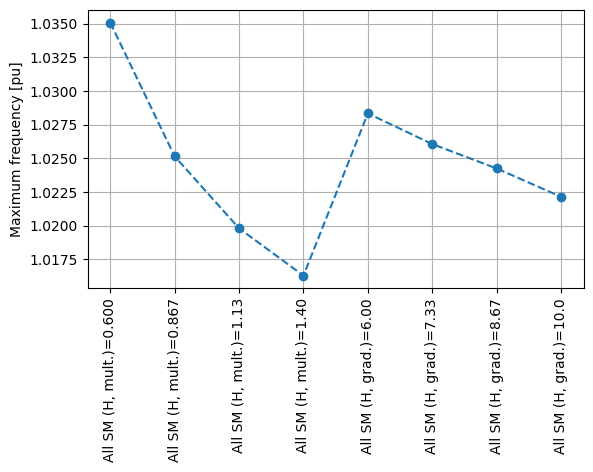

In [62]:
plt.plot(max_frequency.values(), linestyle='--', marker='o')
plt.xticks(
    ticks=list(range(len(max_frequency.keys()))),
    labels=max_frequency.keys(),
)
plt.xticks(rotation=90)
plt.ylabel("Maximum frequency [pu]")
plt.subplots_adjust(bottom=0.3)